# 0.0 Understanding the Situation

- objective of the proposed situation
1. Prediction of the first destination a new user will choose
- Why?
 - What kind of business model does Airbnb have?
 - Market Place (connecting people who offer accommodation with people who are looking for accommodation)
 - Offer (people offer accommodation)
   - Portifolio size
   - Portfolio diversity/density
   - Average price
 - Demand (people looking for accommodation)
   - Number of Users
   - LTV (Lifetime Value)
   - CAC (Client Acquisition Cost)
 - Gross Revenue  = fee * number of users - CAC (contribution margins)
 
 
- **Solution**
 - Prediction model of the first destination of a new user
 - API
   - **Input**: user and its characteristics
   - **Output**: user and its characteristics **with the prediction of destination**

# 1.0 IMPORTS

## 1.1 Libraries

In [60]:
#!pip install scikit-plot

In [65]:
import random
import pandas as pd # pip install pandas
from sklearn.model_selection import train_test_split # pip install sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from scikitplot.metrics import plot_confusion_matrix # pip install scikit-plot
from keras.models import Sequential # pip install keras; pip install tensorflow
from keras.layers import Dense

## 1.2 Helper Functions

## 1.3 Loading data

In [5]:
!ls -l ../01-Data/csv_data

total 648652
-rw-r--r-- 1 fabio 197609     11905 Oct 16  2015 age_gender_bkts.csv
-rw-r--r-- 1 fabio 197609       632 Oct 16  2015 countries.csv
-rw-r--r-- 1 fabio 197609    931451 Dec  6  2015 sample_submission_NDF.csv
-rw-r--r-- 1 fabio 197609 631646292 Dec  6  2015 sessions.csv
-rw-r--r-- 1 fabio 197609   6763170 May 16  2018 test_users.csv
-rw-r--r-- 1 fabio 197609  24853881 Dec 10  2015 train_users_2.csv


### 1.3.1 Training

In [6]:
df_train_raw = pd.read_csv("../01-Data/csv_data/train_users_2.csv", low_memory=True)
df_train_raw.shape

(213451, 16)

### 1.3.2 Sessions

In [7]:
df_sessions_raw = pd.read_csv("../01-Data/csv_data/sessions.csv", low_memory=True)
df_sessions_raw.shape

(10567737, 6)

# 2.0 DATA DESCRIPTION

In [8]:
df_train_01 = df_train_raw.copy()

## 2.1 Training

### 2.1.1 Data Dimensions

In [9]:
print(f'Number of Rows: {df_train_01.shape[0]}')
print(f'Number of Columns: {df_train_01.shape[1]}')

Number of Rows: 213451
Number of Columns: 16


### 2.1.2 Data Type

In [10]:
df_train_01.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### 2.1.3 NA Check

In [12]:
df_train_01.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [15]:
# remove missing values completely
df_train_01 = df_train_01.dropna()
df_train_01.shape

(68171, 16)

### 2.1.4 Change Data type 

In [17]:
# date_account_created
df_train_01['date_account_created'] = pd.to_datetime(df_train_01['date_account_created'])
# timestamp_first_active
df_train_01['timestamp_first_active'] = pd.to_datetime(df_train_01['timestamp_first_active'], format='%Y%m%d%H%M%S')
# date_first_booking
df_train_01['date_first_booking'] = pd.to_datetime(df_train_01['date_first_booking'])

# age
df_train_01['age'] = df_train_01['age'].astype(int)

In [18]:
df_train_01.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

### 2.1.5 Check Balanced Data

In [19]:
df_train_01['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3.0 Data Filtering

In [20]:
df_train_02 = df_train_01.copy()

# 4.0 Data Preparation

In [43]:
df_train_03 = df_train_02.copy()

In [44]:
## Dummy variable
df_train_03_dummy = pd.get_dummies(df_train_03.drop(['id', 'country_destination'], axis=1))

# Join id and country_destination
df_train_03 = pd.concat([df_train_03[['id', 'country_destination']], df_train_03_dummy], axis=1)

# 5.0 Feature Selection

## 5.1 Drop Columns

In [45]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'id'] ## orginal dates
df_train_04 = df_train_03.drop(cols_drop, axis=1)

## 5.2 Split into Train and Validation 

In [52]:
X = df_train_04.drop('country_destination', axis=1)
y = df_train_04['country_destination'].copy()

# Split dataset into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=32)

# 6.0 Machine Learning Model

## 6.1 Baseline model

### 6.1.1 Random Choices

In [70]:
country_destination_list = y_train.drop_duplicates().sort_values().tolist()
country_destination_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_valid.shape[0]

# Random Model

yhat_random = random.choices(population=country_destination_list,
                                weights=country_destination_weights,
                                k=k_num)


### 6.1.2 Random Choices Performance

Accuracy: 0.5177117711771178
Balanced Accuracy: 0.08882382520673734
Kappa Score: 0.00011901943110159685
              precision    recall  f1-score   support

          AU       0.02      0.02      0.02       101
          CA       0.01      0.00      0.00       214
          DE       0.01      0.01      0.01       170
          ES       0.02      0.02      0.02       345
          FR       0.05      0.05      0.05       710
          GB       0.02      0.02      0.02       344
          IT       0.04      0.03      0.03       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.11      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

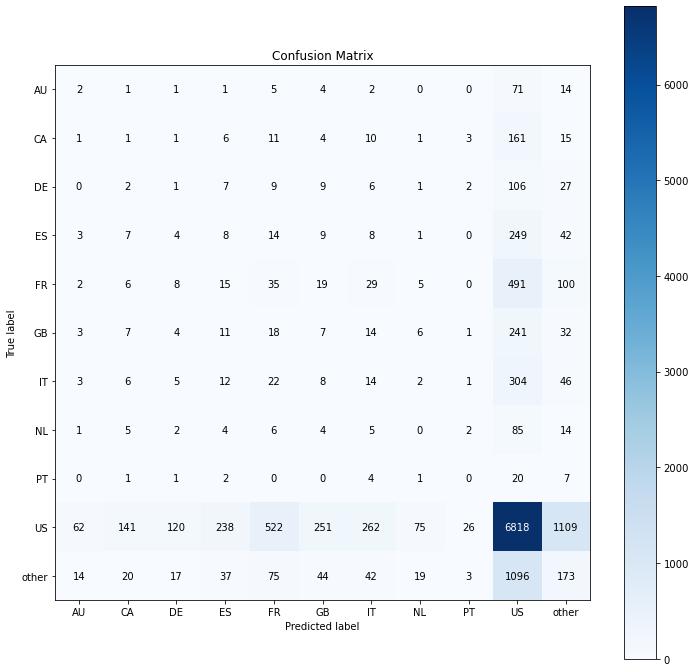

In [71]:
# Accuracy
acc_random = accuracy_score(y_valid, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_valid, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_valid, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_valid, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_valid, yhat_random, normalize=False, figsize=(12,12))

## 6.2 Machine Learning Model - Neural Network MLP

### 6.2.1 Target Encoding

In [53]:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

### 6.2.2 NN Model

In [54]:
# Model Definition
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(11, activation='softmax'))

# Model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train Model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 1s 619us/step - loss: 1.4373 - accuracy: 0.6964
Epoch 2/100
1705/1705 [==============================] - 1s 607us/step - loss: 1.2733 - accuracy: 0.7077
Epoch 3/100
1705/1705 [==============================] - 1s 605us/step - loss: 1.2473 - accuracy: 0.7037
Epoch 4/100
1705/1705 [==============================] - 1s 599us/step - loss: 1.1905 - accuracy: 0.7083
Epoch 5/100
1705/1705 [==============================] - 1s 606us/step - loss: 1.1834 - accuracy: 0.7094
Epoch 6/100
1705/1705 [==============================] - 1s 677us/step - loss: 1.1641 - accuracy: 0.7081
Epoch 7/100
1705/1705 [==============================] - 1s 654us/step - loss: 1.1452 - accuracy: 0.7118
Epoch 8/100
1705/1705 [==============================] - 1s 648us/step - loss: 1.1423 - accuracy: 0.7099
Epoch 9/100
1705/1705 [==============================] - 1s 624us/step - loss: 1.1329 - accuracy: 0.7106
Epoch 10/100
1705/1705 [==============================]

1705/1705 [==============================] - 1s 640us/step - loss: 1.0926 - accuracy: 0.7128
Epoch 79/100
1705/1705 [==============================] - 1s 617us/step - loss: 1.0854 - accuracy: 0.7149
Epoch 80/100
1705/1705 [==============================] - 1s 600us/step - loss: 1.0899 - accuracy: 0.7131
Epoch 81/100
1705/1705 [==============================] - 1s 612us/step - loss: 1.0919 - accuracy: 0.7131
Epoch 82/100
1705/1705 [==============================] - 1s 594us/step - loss: 1.1068 - accuracy: 0.7080
Epoch 83/100
1705/1705 [==============================] - 1s 601us/step - loss: 1.1011 - accuracy: 0.7098
Epoch 84/100
1705/1705 [==============================] - 1s 595us/step - loss: 1.1030 - accuracy: 0.7097
Epoch 85/100
1705/1705 [==============================] - 1s 594us/step - loss: 1.1016 - accuracy: 0.7089
Epoch 86/100
1705/1705 [==============================] - 1s 612us/step - loss: 1.0927 - accuracy: 0.7126
Epoch 87/100
1705/1705 [==============================] - 1

### 6.2.3 NN Performance

In [57]:
# Prediction
pred_nn = model.predict(X_valid)

# Inver Prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# Prediction Prepare
y_valid_nn = y_valid.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.7026035936927026
Balanced Accuracy: 0.09131629136063238
Kappa Score: -0.0003689012334029407


C:\Users\fabio\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.33      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.99      0.83      9624
       other       0.14      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.11      0.09      0.08     13635
weighted avg       0.52      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

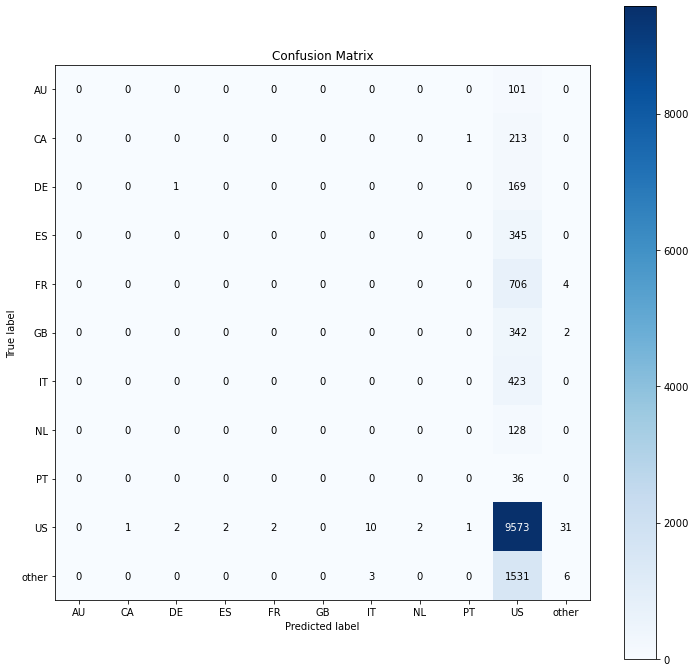

In [66]:
# Accuracy
acc_nn = accuracy_score(y_valid_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = balanced_accuracy_score(y_valid_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Score
kappa_nn = cohen_kappa_score(y_valid_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification Report
print(classification_report(y_valid_nn, yhat_nn))

# Confusion matrix
plot_confusion_matrix(y_valid_nn, yhat_nn, normalize=False, figsize=(12,12))